In [1]:
%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import math, gillespy2
from gillespy2.solvers.cpp.ssa_c_solver import SSACSolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver
from gillespy2.solvers.python.basic_ssa_solver import BasicSSASolver

2019-01-28 08:28:18,058 - root - WARNING -  Unable to use Cython optimized SSA: No module named 'pyximport'. The performance of this package can be significantly increased if you install Cython.


Using matplotlib backend: TkAgg


In [2]:
class DayModel(gillespy2.Model):
    def __init__(self, parameter_values=None, init_v=0):
        # initialize
        gillespy2.Model.__init__(self, name="Macrophage")
        
        # species
        S_ = gillespy2.Species(name='S_', initial_value=4e3) # low = 4e3; mid = 2e4; high = 1e7
        
        A_ = gillespy2.Species(name='A_', initial_value=6e9) # A = Sa/(k2*S+MuA)
        
        H1 = gillespy2.Species(name='H1', initial_value=0)
        H2 = gillespy2.Species(name='H2', initial_value=0)
        H3 = gillespy2.Species(name='H3', initial_value=0)
        H4 = gillespy2.Species(name='H4', initial_value=0)
        H5 = gillespy2.Species(name='H5', initial_value=0)
        H6 = gillespy2.Species(name='H6', initial_value=0)
        
        HLN1 = gillespy2.Species(name='HLN1', initial_value=0)
        HLN2 = gillespy2.Species(name='HLN2', initial_value=0)
        HLN3 = gillespy2.Species(name='HLN3', initial_value=0)
        HLN4 = gillespy2.Species(name='HLN4', initial_value=0)
        HLN5 = gillespy2.Species(name='HLN5', initial_value=0)
        HLN6 = gillespy2.Species(name='HLN6', initial_value=0)
        
        self.add_species([S_,A_,H1,H2,H3,H4,H5,H6,HLN1,HLN2,HLN3,HLN4,HLN5,HLN6])
        
        # parameters
        # num(spores) per macrophage
        ns = gillespy2.Parameter(name='ns', expression=3) # avg = 3.38
        
        # rate of phagocytosis
        k2 = gillespy2.Parameter(name='k2', expression=1e-12)
        
        # migration to TMLN
        k3 = gillespy2.Parameter(name='k3', expression=0.25)

        # source of macrophages per hour
        Sa = gillespy2.Parameter(name='Sa', expression=3e8)
        
        # decay rate of macrophages
        MuA = gillespy2.Parameter(name='MuA', expression=0.05)
        
        self.add_parameter([ns,k2,k3,Sa,MuA])
        
        # reactions
        R1 = gillespy2.Reaction(
            name='R1',
            reactants={S_:1, A_:1},
            products={H1:1},
            rate=k2
        )
        
        R2 = gillespy2.Reaction(
            name='R2',
            reactants={S_:1, H1:1},
            products={H2:1},
            rate=k2
        )
        
        R3 = gillespy2.Reaction(
            name='R3',
            reactants={S_:1, H2:1},
            products={H3:1},
            rate=k2
        )
        
        R4 = gillespy2.Reaction(
            name='R4',
            reactants={S_:1, H3:1},
            products={H4:1},
            rate=k2
        )
        
        R5 = gillespy2.Reaction(
            name='R5',
            reactants={S_:1, H4:1},
            products={H5:1},
            rate=k2
        )
        
        R6 = gillespy2.Reaction(
            name='R6',
            reactants={S_:1, H5:1},
            products={H6:1},
            rate=k2
        )
        
        # To the lung
        R7 = gillespy2.Reaction(
            name='R7',
            reactants={H1:1},
            products={HLN1:1},
            rate=k3
        )
        
        R8 = gillespy2.Reaction(
            name='R8',
            reactants={H2:1},
            products={HLN2:1},
            rate=k3
        )
        
        R9 = gillespy2.Reaction(
            name='R9',
            reactants={H3:1},
            products={HLN3:1},
            rate=k3
        )
        
        R10 = gillespy2.Reaction(
            name='R10',
            reactants={H4:1},
            products={HLN4:1},
            rate=k3
        )
        
        R11 = gillespy2.Reaction(
            name='R11',
            reactants={H5:1},
            products={HLN5:1},
            rate=k3
        )
        
        R12 = gillespy2.Reaction(
            name='R12',
            reactants={H6:1},
            products={HLN6:1},
            rate=k3
        )
                
        self.add_reaction([R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12])
        t = numpy.linspace(0,40,801)
        self.timespan(t)
        #print(t)

In [3]:
model = DayModel()

In [4]:
%time results = model.run(solver=BasicSSASolver)

CPU times: user 93.8 ms, sys: 15.6 ms, total: 109 ms
Wall time: 105 ms


Initial spores: 4000
Spores remaining: 3128
Spores at 5 hours: 3880


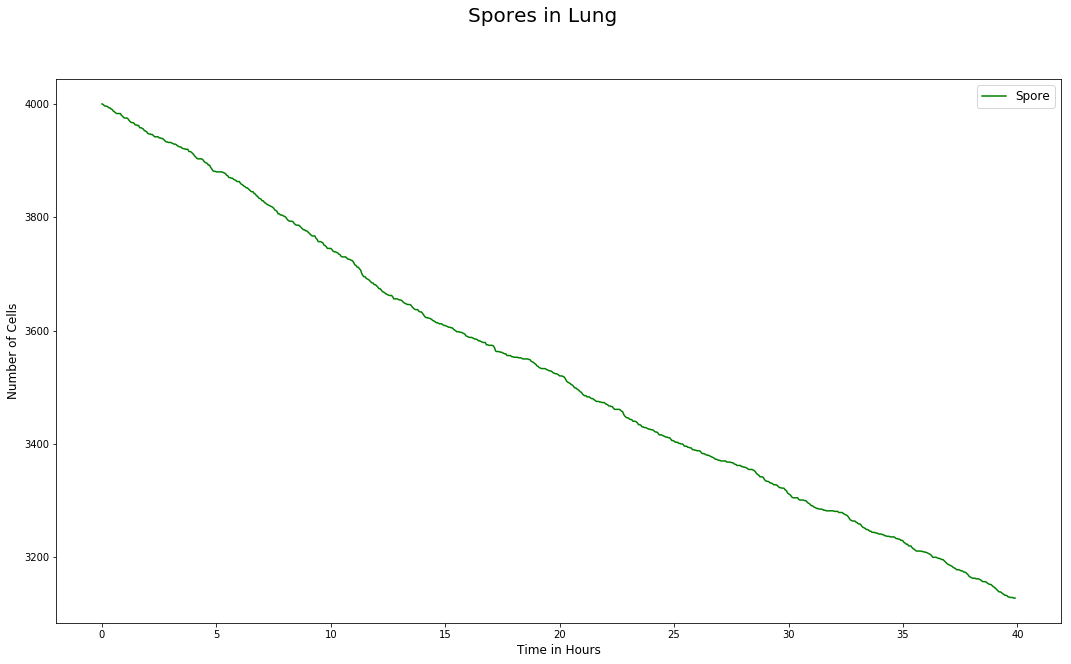

In [5]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores in Lung", fontsize=20)

plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
print("Initial spores: {}".format(results[0]['S_'][0]))
print("Spores remaining: {}".format(results[0]['S_'][-1]))
print("Spores at 5 hours: {}".format(results[0]['S_'][100]))


Lung Hosts at end:
H1: 74
H2: 0
H3: 0
H4: 0
H5: 0
H6: 0


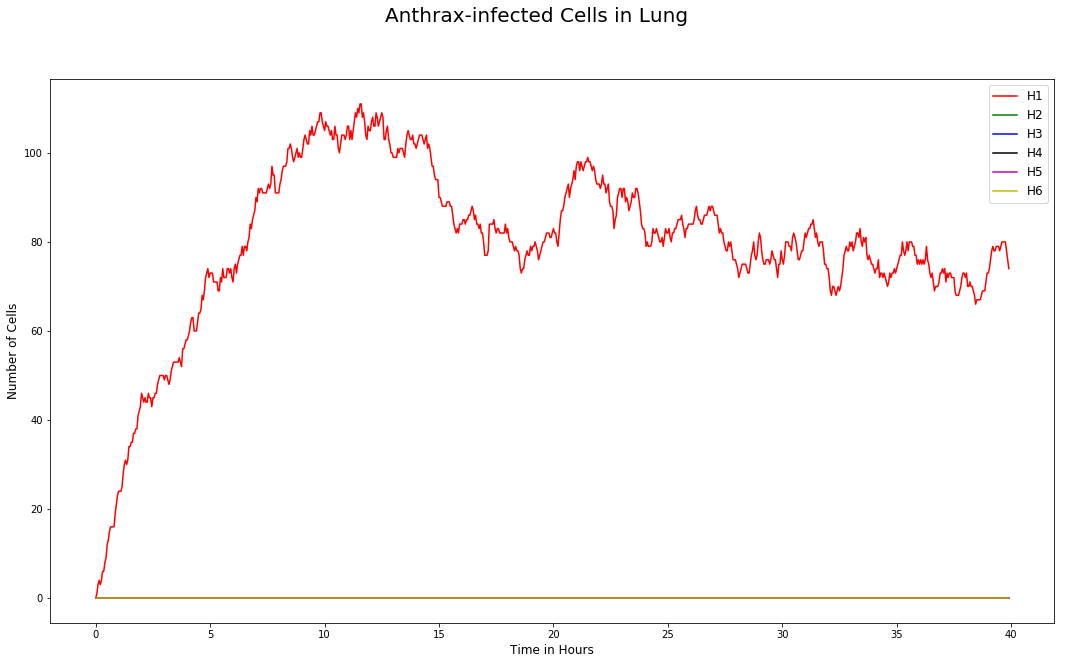

In [6]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(results[0]['time'], results[0]['H1'], 'r-', label='H1')
plt.plot(results[0]['time'], results[0]['H2'], 'g-', label='H2')
plt.plot(results[0]['time'], results[0]['H3'], 'b-', label='H3')
plt.plot(results[0]['time'], results[0]['H4'], 'k-', label='H4')
plt.plot(results[0]['time'], results[0]['H5'], 'm-', label='H5')
plt.plot(results[0]['time'], results[0]['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("Lung Hosts at end:")
print("H1: {}".format(results[0]['H1'][-1]))
print("H2: {}".format(results[0]['H2'][-1]))
print("H3: {}".format(results[0]['H3'][-1]))
print("H4: {}".format(results[0]['H4'][-1]))
print("H5: {}".format(results[0]['H5'][-1]))
print("H6: {}".format(results[0]['H6'][-1]))




k2 = 1.00e-12, k3 = 2.50e-01
Lung Hosts at end:
H1: 74
H2: 0
H3: 0
H4: 0
H5: 0
H6: 0
Lymph Node Hosts at end:
HLN1: 798
HLN2: 0
HLN3: 0
HLN4: 0
HLN5: 0
HLN6: 0


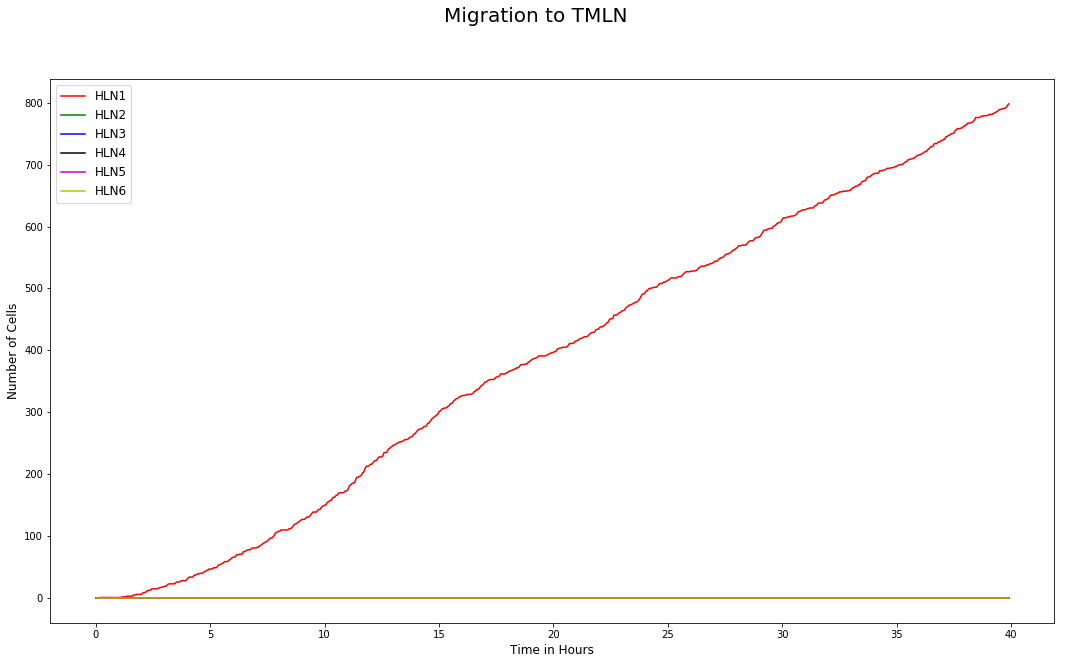

In [10]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(results[0]['time'], results[0]['HLN1'], 'r-', label='HLN1')
plt.plot(results[0]['time'], results[0]['HLN2'], 'g-', label='HLN2')
plt.plot(results[0]['time'], results[0]['HLN3'], 'b-', label='HLN3')
plt.plot(results[0]['time'], results[0]['HLN4'], 'k-', label='HLN4')
plt.plot(results[0]['time'], results[0]['HLN5'], 'm-', label='HLN5')
plt.plot(results[0]['time'], results[0]['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("k2 = {:.2e}, k3 = {:.2e}".format(float(model.listOfParameters['k2'].expression), float(model.listOfParameters['k3'].expression)))

print("Lung Hosts at end:")
print("H1: {}".format(results[0]['H1'][-1]))
print("H2: {}".format(results[0]['H2'][-1]))
print("H3: {}".format(results[0]['H3'][-1]))
print("H4: {}".format(results[0]['H4'][-1]))
print("H5: {}".format(results[0]['H5'][-1]))
print("H6: {}".format(results[0]['H6'][-1]))

print("Lymph Node Hosts at end:")
print("HLN1: {}".format(results[0]['HLN1'][-1]))
print("HLN2: {}".format(results[0]['HLN2'][-1]))
print("HLN3: {}".format(results[0]['HLN3'][-1]))
print("HLN4: {}".format(results[0]['HLN4'][-1]))
print("HLN5: {}".format(results[0]['HLN5'][-1]))
print("HLN6: {}".format(results[0]['HLN6'][-1]))

In [ ]:
data = [
    results[0]['HLN1'][-1],
    results[0]['HLN2'][-1],
    results[0]['HLN3'][-1],
    results[0]['HLN4'][-1],
    results[0]['HLN5'][-1],
    results[0]['HLN6'][-1]
]
x = [1,2,3,4,5,6]
plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

2019-01-28 08:28:23,881 - tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x7fe331cc7048>)
Traceback (most recent call last):
  File "/home/george/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/george/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/george/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 306, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable
